# Network Analysis on Auckland road data
### Import packages

In [75]:
import numpy as np
import pandas as pd
import osmnx as ox
import geopandas as gpd
from shapely.geometry import MultiPolygon
from shapely.ops import transform
import pyproj
import math

### Importing territorial boundry of Auckland region

In [51]:
auckland_path = "data/geographic/territorial/auckland_territory.gpkg"

In [52]:
auckland = gpd.read_file(auckland_path)
auckland = auckland.to_crs(crs=4326)
polygon = auckland2.iloc[0]['geometry']

### Generating or importing the road network

In [118]:
G = ox.graph.graph_from_polygon(polygon, network_type="walk")
#G = ox.io.load_graphml("data/network_analysis/auckland_network_walk_consolidated.graphml")

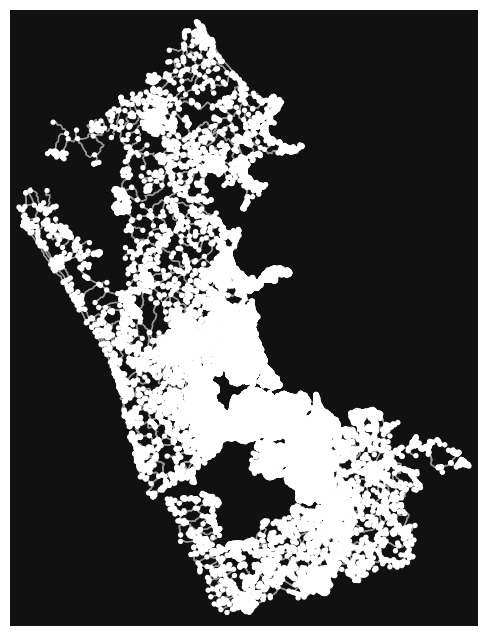

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [119]:
ox.plot_graph(G2)

### Consolidate the newtork to solve the spatial/topological issue

In [55]:
ox.simplification.consolidate_intersections(G, rebuild_graph=True)

/opt/miniconda3/envs/ox/lib/python3.10/site-packages/osmnx/simplification.py:426: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged = utils_graph.graph_to_gdfs(G, edges=False)["geometry"].buffer(tolerance).unary_union
/opt/miniconda3/envs/ox/lib/python3.10/site-packages/osmnx/simplification.py:474: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = node_clusters.centroid


### Save the newtork for later cos it took long to download it

In [115]:
ox.io.save_graphml(G, filepath="data/auckland_network_walk_consolidated.graphml", gephi=False, encoding='utf-8')

# Adding other data
### Import the grid of urban Auckland including census variables
The IDW was done in R. Code in the file data-prep.R

<AxesSubplot: >

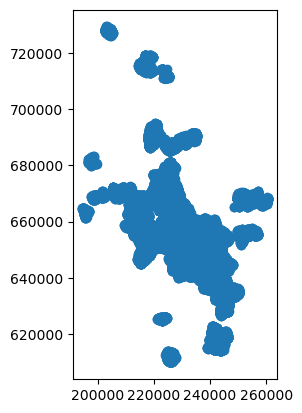

In [65]:
grid = gpd.read_file("data/geographic/grids/grid_50000_auckland_census.gpkg")
grid['lon'] = grid['geometry'].x
grid['lat'] = grid['geometry'].y
grid.plot()

### Or read in with distances

In [127]:
grid = gpd.read_file("data/geographic/grids/grid_50000_auckland_census_dist.gpkg")
grid.head()

,income,no_households,maori_pr,dampness,lon,lat,ne_u,ne_v,ne_dist,geometry
0,36710.691419,50.796403,0.201352,127.790087,225532.509406,609808.736016,9872095432,7543967816,0,POINT (225532.509 609808.736)
1,36882.949283,50.309440,0.198384,126.097575,225657.352287,609808.736016,9872095432,7543967816,0,POINT (225657.352 609808.736)
2,37549.885003,48.335262,0.197472,124.746673,225782.195169,609808.736016,9872095432,7543967816,0,POINT (225782.195 609808.736)
3,38054.679447,47.356256,0.189796,117.682066,225907.038050,609808.736016,9872095432,7543967816,0,POINT (225907.038 609808.736)
4,38253.993943,47.114833,0.185706,115.530078,226031.880931,609808.736016,9872095432,7543967816,0,POINT (226031.881 609808.736)


### Snap the grid of points to the nearest road egde
This is so that I can later calculate network distances between each point to the supply points

In [124]:
grid[["ne_u","ne_v","ne_dist"]] = ox.distance.nearest_edges(G, X=grid["lon"], Y=grid["lat"])
grid.head()

,income,no_households,maori_pr,dampness,geometry,lon,lat,ne_u,ne_v,ne_dist
0,36710.691419,50.796403,0.201352,127.790087,POINT (225532.509 609808.736),225532.509406,609808.736016,9872095432,7543967816,0
1,36882.949283,50.309440,0.198384,126.097575,POINT (225657.352 609808.736),225657.352287,609808.736016,9872095432,7543967816,0
2,37549.885003,48.335262,0.197472,124.746673,POINT (225782.195 609808.736),225782.195169,609808.736016,9872095432,7543967816,0
3,38054.679447,47.356256,0.189796,117.682066,POINT (225907.038 609808.736),225907.038050,609808.736016,9872095432,7543967816,0
4,38253.993943,47.114833,0.185706,115.530078,POINT (226031.881 609808.736),226031.880931,609808.736016,9872095432,7543967816,0


Save the grid with nearest edge for future use

In [125]:
grid.to_file("data/geographic/grids/grid_50000_auckland_census.gpkg", layer='grid', driver="GPKG")

### Import the train stations in Auckland
The IDW was done in R. Code in the file data-prep.R

<AxesSubplot: >

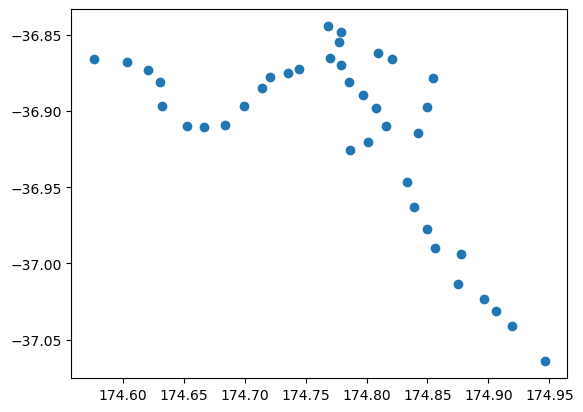

In [104]:
stations = gpd.read_file("data/transport/public_transport/trains_auckland.gpkg")
stations['lon'] = stations['geometry'].x
stations['lat'] = stations['geometry'].y
stations.plot()

### Snap the train station points to the nearest road egde
This is for later calculation of network distances between each station to the demand points - grid

In [105]:
stations[["u", "v", "dist"]] = ox.distance.nearest_edges(G, X=stations["lon"], Y=stations["lat"])
stations.head()

/opt/miniconda3/envs/ox/lib/python3.10/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))


,OBJECTID,STOPID,STOPCODE,STOPNAME,STOPDESC,LOCATIONTYPE,STOPLAT,STOPLON,PARENTSTATION,MODE,geometry,lon,lat,u,v,dist
0,1,97,97,Papakura Train Station,None,Stop,-37.064294,174.946114,None,Train,POINT (174.94611 -37.06429),174.946114,-37.064294,1071743678,5882816768,0
1,2,98,98,Manurewa Train Station,None,Stop,-37.023268,174.896171,None,Train,POINT (174.89617 -37.02327),174.896171,-37.023268,3843898501,7870811398,0
2,3,125,125,Henderson Train Station,None,Stop,-36.880965,174.630910,None,Train,POINT (174.63091 -36.88097),174.630910,-36.880965,8323389695,711693102,0
3,4,127,127,Swanson Train Station,None,Stop,-36.866181,174.576300,None,Train,POINT (174.57630 -36.86618),174.576300,-36.866181,9393064946,3490204785,0
4,5,113,113,Greenlane Train Station,None,Stop,-36.889657,174.797419,None,Train,POINT (174.79742 -36.88966),174.797419,-36.889657,26010886,26010873,0


In [107]:
stations.to_file("data/transport/public_transport/trains_auckland_with_distances_on_network.gpkg", layer='grid', driver="GPKG")

## Continue here

In [ ]:
grid["nearest_point_on_edge"] = edge_geom.interpolate(edge_geom.project(point_geom))
nearest_point_on_edge.coords[0]